# Predicting Future Trends in Sea Surface Temperature

In [ ]:
# !pip install --upgrade google-cloud-bigquery

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery


In [ ]:
# auth.authenticate_user()

# project_id = 'bamboo-medium-450316-m8'
# client = bigquery.Client(project=project_id)


In [ ]:
!pip install copernicusmarine

# Step 1: Install the Copernicus Marine Toolbox
import copernicusmarine

# Step 2: Login with Your Copernicus Marine Credentials
copernicusmarine.login(username="samikshakhare22@gmail.com", password="Counter@1")


File /root/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]: y


INFO - 2025-05-05T08:26:44Z - Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.
INFO:copernicusmarine:Credentials file stored in /root/.copernicusmarine/.copernicusmarine-credentials.


True

In [ ]:
# Subset

copernicusmarine.subset(
   dataset_id = "METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2",
   variables = ["analysed_sst"],
   start_datetime = "2011-01-01T00:00:00",
   end_datetime = "2024-12-31T23:59:59",
   minimum_longitude = -59.75,
   maximum_longitude = -59.40,
   minimum_latitude = 12.95,
   maximum_latitude = 13.25,
   minimum_depth = 0,
   maximum_depth = 1,
   output_filename = "sst_data_for_major_locations.nc",
   output_directory = "copernicus-data"
)

INFO - 2025-05-05T08:28:51Z - Selected dataset version: "default"
INFO:copernicusmarine:Selected dataset version: "default"
INFO - 2025-05-05T08:28:51Z - Selected dataset part: "default"
INFO:copernicusmarine:Selected dataset part: "default"
INFO - 2025-05-05T08:28:59Z - Starting download. Please wait...
INFO:copernicusmarine:Starting download. Please wait...


  0%|          | 0/10 [00:00<?, ?it/s]

INFO - 2025-05-05T08:29:02Z - Successfully downloaded to copernicus-data/sst_data_for_major_locations.nc
INFO:copernicusmarine:Successfully downloaded to copernicus-data/sst_data_for_major_locations.nc


ResponseSubset(file_path=PosixPath('copernicus-data/sst_data_for_major_locations.nc'), output_directory=PosixPath('copernicus-data'), filename='sst_data_for_major_locations.nc', file_size=0.42290076335877863, data_transfer_size=48.659541984732826, variables=['analysed_sst'], coordinates_extent=[GeographicalExtent(minimum=-59.724998474121094, maximum=-59.42499923706055, unit='degrees_east', coordinate_id='longitude'), GeographicalExtent(minimum=12.975000381469727, maximum=13.225000381469727, unit='degrees_north', coordinate_id='latitude'), TimeExtent(minimum='2011-01-01T00:00:00+00:00', maximum='2024-12-31T00:00:00+00:00', unit='iso8601', coordinate_id='time')], status='000', message='The request was successful.', file_status='DOWNLOADED')

In [ ]:
import xarray as xr

# Open the NetCDF file
ds = xr.open_dataset('/content/copernicus-data/sst_data_for_major_locations.nc')
print(ds)

<xarray.Dataset> Size: 2MB
Dimensions:       (time: 5114, latitude: 6, longitude: 7)
Coordinates:
  * latitude      (latitude) float32 24B 12.98 13.02 13.07 13.12 13.18 13.23
  * longitude     (longitude) float32 28B -59.72 -59.67 -59.62 ... -59.47 -59.42
  * time          (time) datetime64[ns] 41kB 2011-01-01 ... 2024-12-31
Data variables:
    analysed_sst  (time, latitude, longitude) float64 2MB ...
Attributes:
    source:                    AVHRR18_G-NAVO-L2P-V1.0, AVHRR19_G-NAVO-L2P-V1...
    history:                   Created from sst.nc; obs_anal.nc; seaice.nc
    comment:                   WARNING Some applications are unable to proper...
    Conventions:               CF-1.4, ACDD-1.3
    references:                Good S, Fiedler E, Mao C, Martin MJ, Maycock A...
    title:                     Global SST & Sea Ice Analysis, L4 OSTIA, 0.05 ...
    institution:               UKMO
    copernicusmarine_version:  2.0.1


In [ ]:
# Flatten and convert to dataframe
df = ds['analysed_sst'].to_dataframe().reset_index()

In [ ]:
df.head()

,time,latitude,longitude,analysed_sst
0,2011-01-01,12.975,-59.724998,300.899993
1,2011-01-01,12.975,-59.674999,300.899993
2,2011-01-01,12.975,-59.625000,300.899993
3,2011-01-01,12.975,-59.575001,300.889993
4,2011-01-01,12.975,-59.525002,300.889993


# Data Exploration

In [ ]:
df.shape

(214788, 4)

In [ ]:
import numpy as np

# Load coordinate arrays from dataset
latitudes = ds.latitude.values
longitudes = ds.longitude.values

# Known coastal coordinates (approximate)
locations = {
    "Crane Beach": (13.1089, -59.4414),
    "Oistins": (13.0647, -59.5515),
    "Conset Bay": (13.2025, -59.4827)
}

# Find nearest available offshore grid point for each location
offshore_matches = {}

for name, (lat, lon) in locations.items():
    closest_lat = latitudes[np.abs(latitudes - lat).argmin()]
    closest_lon = longitudes[np.abs(longitudes - lon).argmin()]
    offshore_matches[name] = (closest_lat, closest_lon)

offshore_matches


{'Crane Beach': (13.125, -59.425),
 'Oistins': (13.075, -59.575),
 'Conset Bay': (13.225, -59.475)}

In [ ]:
# Extract SST for each offshore location
location_sst = {}

for name, (lat_val, lon_val) in offshore_matches.items():
    sst = ds['analysed_sst'].sel(latitude=lat_val, longitude=lon_val).to_dataframe().reset_index()
    sst['location'] = name  # Add location column
    location_sst[name] = sst

# Combine all locations into one DataFrame
import pandas as pd
df_combined = pd.concat(location_sst.values(), ignore_index=True)

# Preview
df_combined.head()


,time,latitude,longitude,analysed_sst,location
0,2011-01-01,13.125,-59.424999,300.789993,Crane Beach
1,2011-01-02,13.125,-59.424999,300.769993,Crane Beach
2,2011-01-03,13.125,-59.424999,300.699993,Crane Beach
3,2011-01-04,13.125,-59.424999,300.869993,Crane Beach
4,2011-01-05,13.125,-59.424999,300.889993,Crane Beach


## Handle missing values

In [ ]:
df_combined.head()

,time,latitude,longitude,analysed_sst,location
0,2011-01-01,13.125,-59.424999,300.789993,Crane Beach
1,2011-01-02,13.125,-59.424999,300.769993,Crane Beach
2,2011-01-03,13.125,-59.424999,300.699993,Crane Beach
3,2011-01-04,13.125,-59.424999,300.869993,Crane Beach
4,2011-01-05,13.125,-59.424999,300.889993,Crane Beach


In [ ]:
df_combined.isnull().sum()

,0
time,0
latitude,0
longitude,0
analysed_sst,0
location,0


### 1. Line Plot: Sea Surface Temperature Over Time

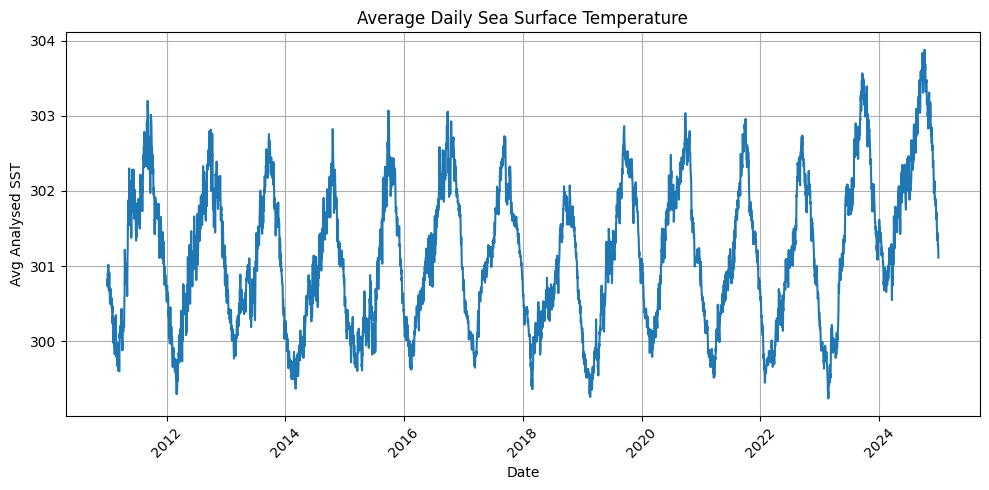

In [ ]:
import matplotlib.pyplot as plt

df_combined['time'] = pd.to_datetime(df_combined['time'])

# Group by date (ignore time part) and calculate mean SST
df_daily_avg = df_combined.groupby(df_combined['time'].dt.date)['analysed_sst'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_daily_avg['time'], df_daily_avg['analysed_sst'])
plt.title('Average Daily Sea Surface Temperature')
plt.xlabel('Date')
plt.ylabel('Avg Analysed SST')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2. Histogram: Distribution of Sea Surface Temperature

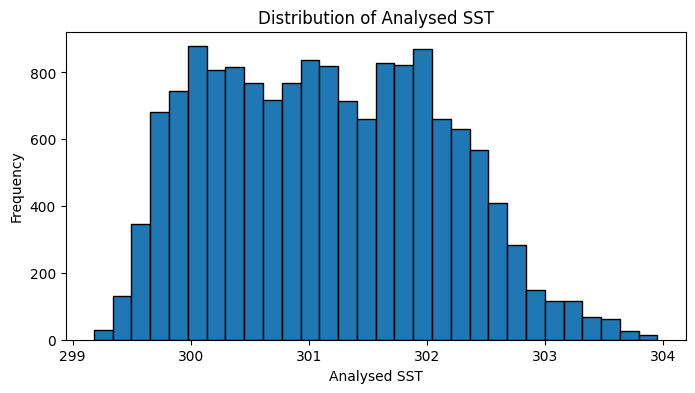

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df_combined['analysed_sst'], bins=30, edgecolor='black')
plt.title('Distribution of Analysed SST')
plt.xlabel('Analysed SST')
plt.ylabel('Frequency')
plt.show()


### 3. Boxplot: SST Distribution by Location

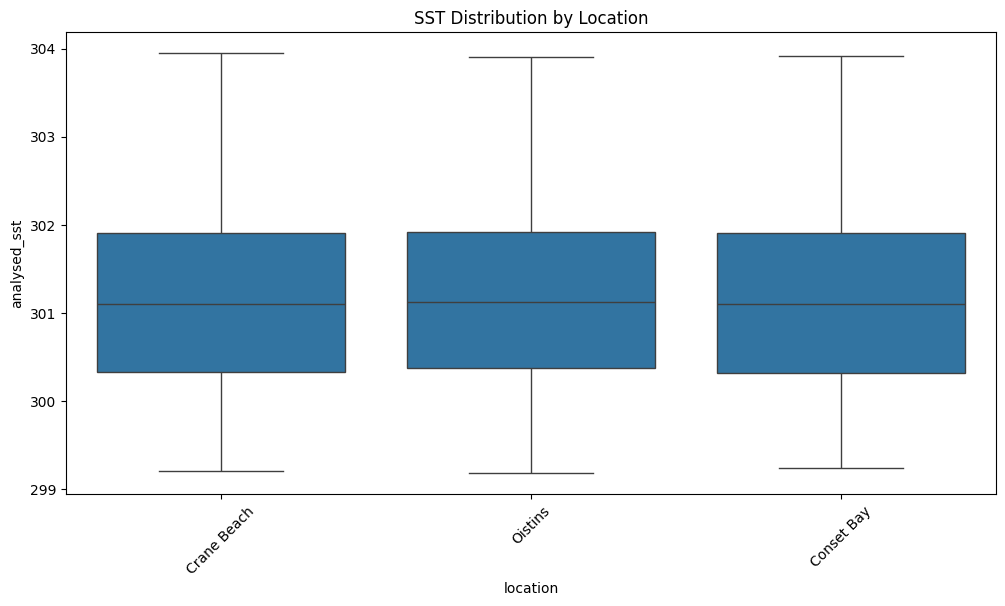

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x='location', y='analysed_sst')
plt.title('SST Distribution by Location')
plt.xticks(rotation=45)
plt.show()



# Linear Regression

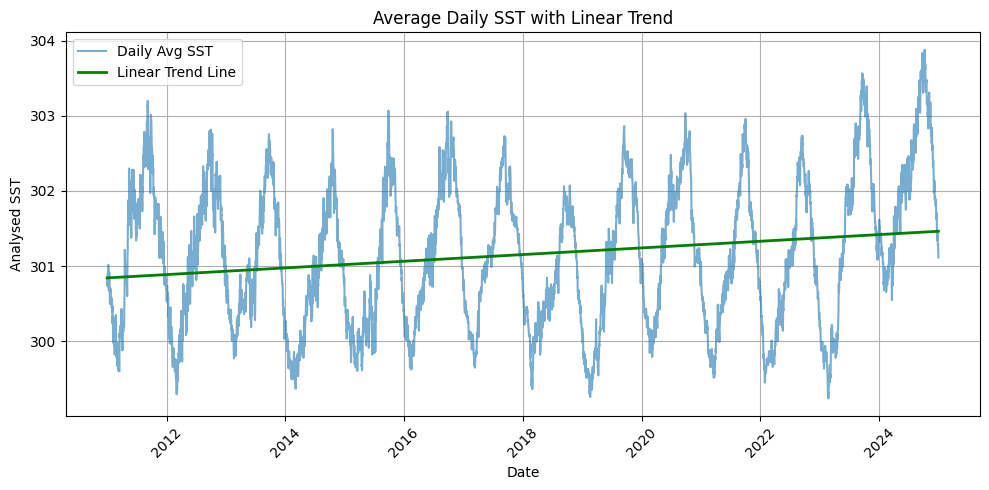

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Convert date to ordinal for regression
df_daily_avg['date_ordinal'] = pd.to_datetime(df_daily_avg['time']).map(pd.Timestamp.toordinal)

# Fit linear regression
model = LinearRegression()
model.fit(df_daily_avg[['date_ordinal']], df_daily_avg['analysed_sst'])

# Predict values
df_daily_avg['trend_line'] = model.predict(df_daily_avg[['date_ordinal']])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df_daily_avg['time'], df_daily_avg['analysed_sst'], label='Daily Avg SST', alpha=0.6)
plt.plot(df_daily_avg['time'], df_daily_avg['trend_line'], label='Linear Trend Line', color='green', linewidth=2)
plt.title('Average Daily SST with Linear Trend')
plt.xlabel('Date')
plt.ylabel('Analysed SST')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


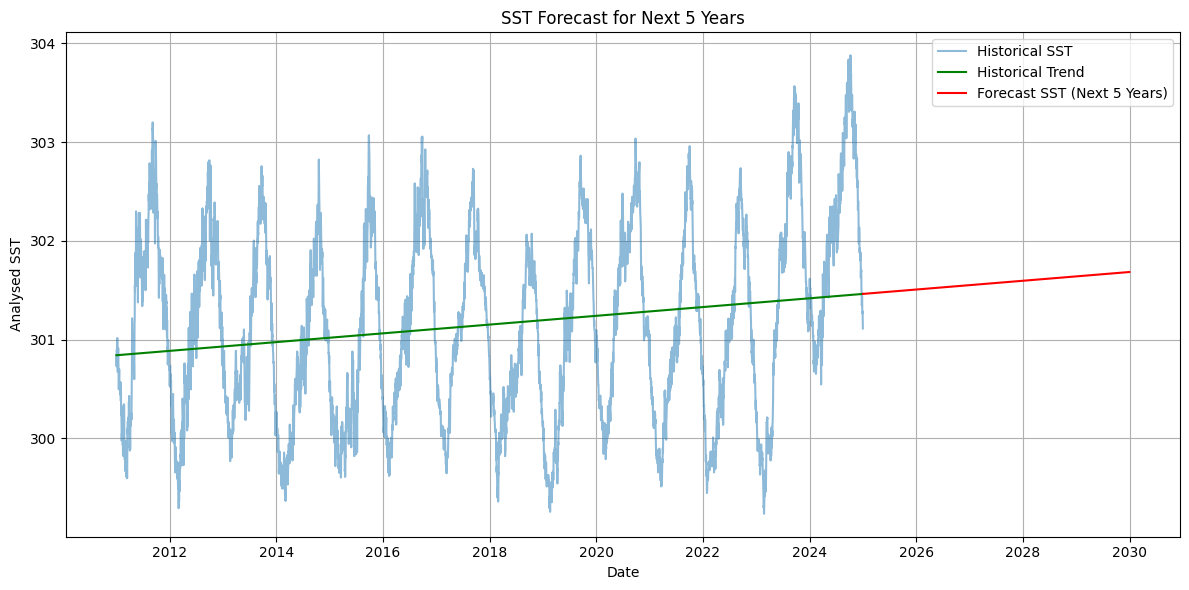

In [ ]:
from datetime import timedelta

# Extend the date range by 5 years from the last date
last_date = df_daily_avg['time'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=5*365, freq='D')  # 5 years

# Convert to ordinal
future_ordinals = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)

# Predict SST for future dates
future_sst = model.predict(future_ordinals)

# Combine into a new DataFrame
future_df = pd.DataFrame({'time': future_dates, 'predicted_sst': future_sst})

# Plot historical + forecast
plt.figure(figsize=(12, 6))
plt.plot(df_daily_avg['time'], df_daily_avg['analysed_sst'], label='Historical SST', alpha=0.5)
plt.plot(df_daily_avg['time'], df_daily_avg['trend_line'], label='Historical Trend', color='green')
plt.plot(future_df['time'], future_df['predicted_sst'], label='Forecast SST (Next 5 Years)', color='red')
plt.title('SST Forecast for Next 5 Years')
plt.xlabel('Date')
plt.ylabel('Analysed SST')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Non Linear Model

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

# Prepare data
prophet_df = df_daily_avg[['time', 'analysed_sst']].rename(columns={'time': 'ds', 'analysed_sst': 'y'})

# Initialize and fit model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa8upae9/ffg6cikt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa8upae9/yvsvlbwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70237', 'data', 'file=/tmp/tmpaa8upae9/ffg6cikt.json', 'init=/tmp/tmpaa8upae9/yvsvlbwv.json', 'output', 'file=/tmp/tmpaa8upae9/prophet_modelcxyzlcty/prophet_model-20250505090539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=5*365)  # 5 years ahead (daily)
forecast = model.predict(future)

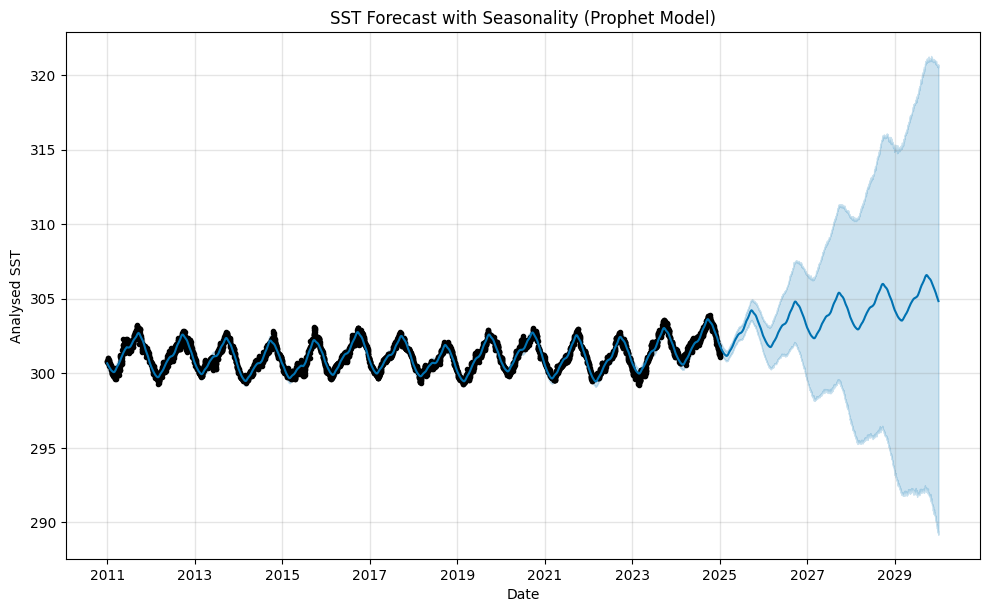

In [ ]:
fig = model.plot(forecast)
plt.title('SST Forecast with Seasonality (Prophet Model)')
plt.xlabel('Date')
plt.ylabel('Analysed SST')
plt.grid(True)
plt.show()


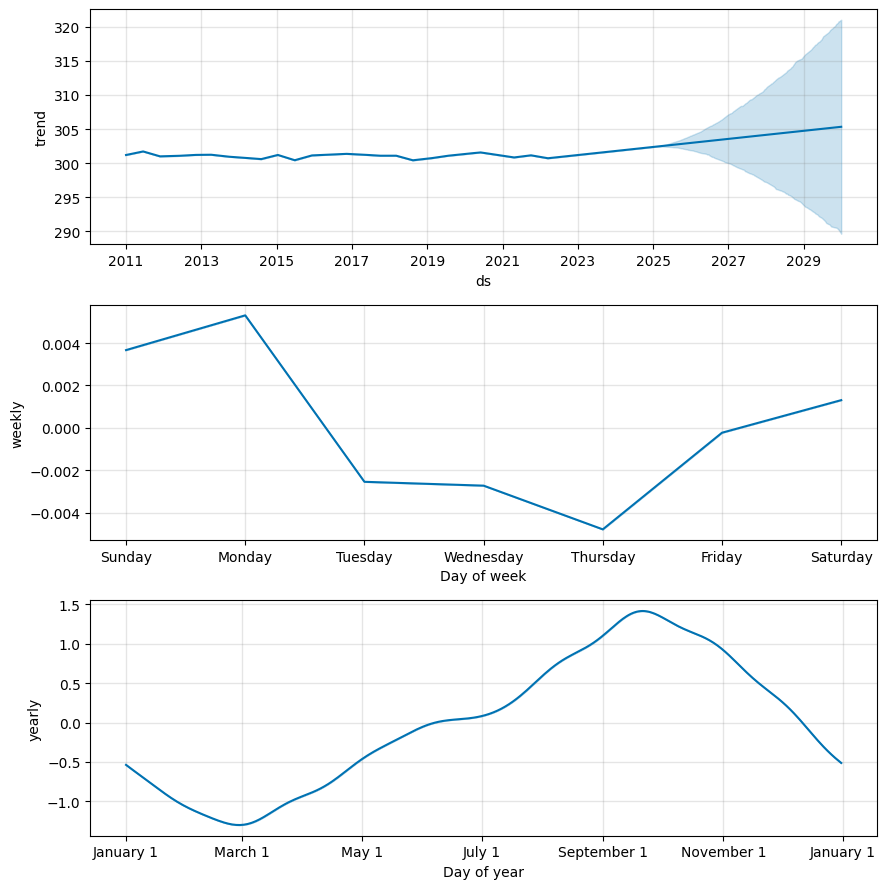

In [ ]:
fig2 = model.plot_components(forecast)


| Plot   | Y-Axis Meaning                               | Effect Size   |
| ------ | -------------------------------------------- | ------------- |
| Weekly | SST deviation by day of week (±0.005 approx) | Tiny impact   |
| Yearly | SST deviation by time of year (±1.5 approx)  | Strong impact |


SST tends to be ~1.5 units above average during peak warm months, and ~1.2 units below average in the colder months — showing a strong seasonal oscillation.

In [60]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 21 forecasts with cutoffs between 2014-02-22 00:00:00 and 2024-01-01 00:00:00


  0%|          | 0/21 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa8upae9/kb48cimk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa8upae9/oail7_q0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3938', 'data', 'file=/tmp/tmpaa8upae9/kb48cimk.json', 'init=/tmp/tmpaa8upae9/oail7_q0.json', 'output', 'file=/tmp/tmpaa8upae9/prophet_modelin4268k2/prophet_model-20250505211928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:19:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa8upae9/r6r_6ccj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaa8upae9/aiubcaa2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.140077,0.374268,0.299600,0.000995,0.000785,0.000995,0.581189
1,38 days,0.143239,0.378469,0.303604,0.001008,0.000799,0.001008,0.574599
2,39 days,0.147452,0.383994,0.308352,0.001024,0.000811,0.001024,0.566766
3,40 days,0.151632,0.389400,0.313015,0.001039,0.000823,0.001040,0.558933
4,41 days,0.155980,0.394944,0.318350,0.001057,0.000855,0.001057,0.549795
